In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from keras.applications import VGG16

In [2]:
train_dir = "/kaggle/input/datahack/hj3vvx5946-1/Splited_dataset/train/"
valid_dir = "/kaggle/input/datahack/hj3vvx5946-1/Splited_dataset/test/"

img_width, img_height = 224, 224

In [3]:
conv_base = VGG16(weights='imagenet', 
                  include_top=False,
                  input_shape=(img_width, img_height, 3))

# Show architecture
conv_base.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [4]:
import os, shutil
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 32

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 7, 7, 512))  # Must be equal to the output of the convolutional base
    labels = np.zeros(shape=(sample_count,48))
    # Preprocess data
    generator = datagen.flow_from_directory(directory,
                                            target_size=(img_width,img_height),
                                            batch_size = batch_size,
                                            class_mode='categorical')
    # Pass data through convolutional base
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size: (i + 1) * batch_size] = features_batch
        labels[i * batch_size: (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels
    
train_features, train_labels = extract_features(train_dir, 3096)  # Agree with our small dataset size
validation_features, validation_labels = extract_features(valid_dir, 751)

Found 3096 images belonging to 48 classes.
1/1 [==============================] - 3s 3s/step
Found 751 images belonging to 48 classes.
1/1 [==============================] - 2s 2s/step


In [5]:
train_labels

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [6]:
epochs = 150

model = Sequential()
model.add(GlobalAveragePooling2D(input_shape=(7,7,512)))
model.add(Dense(200,activation='relu'))
model.add(Dense(48, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 200)               102600    
                                                                 
 dense_1 (Dense)             (None, 48)                9648      
                                                                 
Total params: 112,248
Trainable params: 112,248
Non-trainable params: 0
_________________________________________________________________


In [7]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint('model-{epoch:03d}-{acc:03f}-{val_acc:03f}.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')  

# Compile model
from keras.optimizers import Adam
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['acc'])

# Train model
history = model.fit(train_features, train_labels,
                    epochs=epochs,
                    batch_size=batch_size, 
                    callbacks=[checkpoint],
                    validation_data=(validation_features, validation_labels))

Epoch 1/150
93/97 [===========================>..] - ETA: 0s - loss: 3.5488 - acc: 0.1156
Epoch 1: val_loss improved from inf to 3.37494, saving model to model-001-0.120478-0.178429.h5
97/97 [==============================] - 1s 8ms/step - loss: 3.5439 - acc: 0.1205 - val_loss: 3.3749 - val_acc: 0.1784
Epoch 2/150
89/97 [==========================>...] - ETA: 0s - loss: 3.2403 - acc: 0.1857
Epoch 2: val_loss improved from 3.37494 to 3.09816, saving model to model-002-0.187339-0.193076.h5
97/97 [==============================] - 1s 6ms/step - loss: 3.2322 - acc: 0.1873 - val_loss: 3.0982 - val_acc: 0.1931
Epoch 3/150
85/97 [=========================>....] - ETA: 0s - loss: 2.9644 - acc: 0.2301
Epoch 3: val_loss improved from 3.09816 to 2.89157, saving model to model-003-0.240956-0.245007.h5
97/97 [==============================] - 1s 6ms/step - loss: 2.9436 - acc: 0.2410 - val_loss: 2.8916 - val_acc: 0.2450
Epoch 4/150
97/97 [==============================] - ETA: 0s - loss: 2.6920 - ac

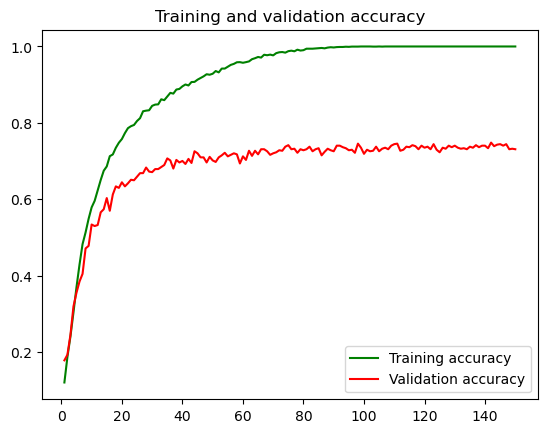

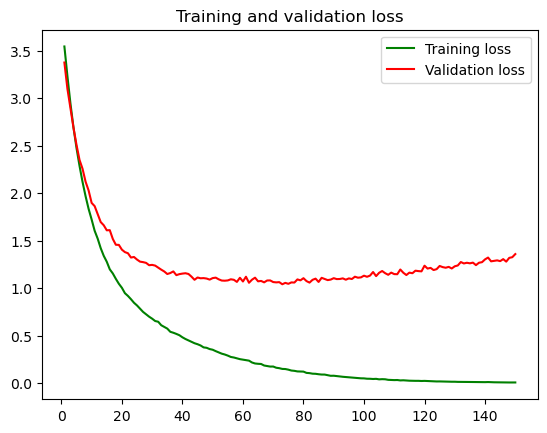

In [8]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [9]:
from tensorflow.keras.preprocessing import image
def prediction(img_path):
    org_img = image.load_img(img_path)
    img = image.load_img(img_path, target_size=(img_width, img_height))
    img_tensor = image.img_to_array(img)  # Image data encoded as integers in the 0–255 range
    img_tensor /= 255.  # Normalize to [0,1] for plt.imshow application
    plt.imshow(org_img)                           
    plt.axis('off')
    plt.show()


    # Extract features
    features = conv_base.predict(img_tensor.reshape(1,img_width, img_height, 3))

    # Make prediction
    try:
        prediction = model.predict(features)
    except:
        prediction = model.predict(features.reshape(1, 7*7*512))
        
    classes = ["Daiatsu_Core", "Daiatsu_Hijet", "Daiatsu_Mira", "FAW_V2", "FAW_XPV", "Honda_BRV", "Honda_City_aspire", "Honda_Grace", "Honda_Vezell", "Honda_city_1994", "Honda_city_2000", "Honda_civic_1994", "Honda_civic_2005", "Honda_civic_2007", "Honda_civic_2015", "Honda_civic_2018", "KIA_Sportage", "Suzuki_Every", "Suzuki_Mehran", "Suzuki_alto_2007", "Suzuki_alto_2019", "Suzuki_alto_japan_2010", "Suzuki_carry", "Suzuki_cultus_2018", "Suzuki_cultus_2019", "Suzuki_highroof", "Suzuki_kyber", "Suzuki_liana", "Suzuki_margala", "Suzuki_swift", "Suzuki_wagonR_2015", "Toyota HIACE 2000", "Toyota_Aqua", "Toyota_Hiace_2012", "Toyota_Landcruser", "Toyota_Passo", "Toyota_Prado", "Toyota_Vigo", "Toyota_Vitz", "Toyota_Vitz_2010", "Toyota_axio", "Toyota_corolla_2000", "Toyota_corolla_2007", "Toyota_corolla_2011", "Toyota_corolla_2016", "Toyota_fortuner", "Toyota_pirus", "Toyota_premio"]
    print("Car is "+str(classes[np.argmax(np.array(prediction[0]))]))

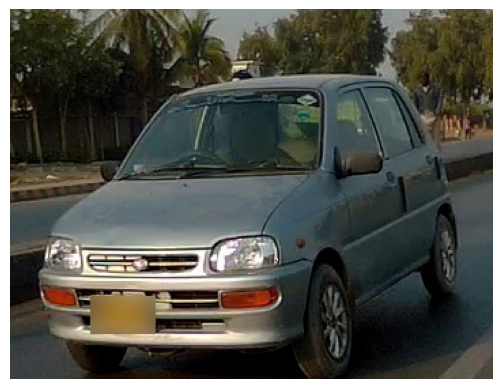

1/1 [==============================] - 0s 66ms/step
Car is Daiatsu_Core


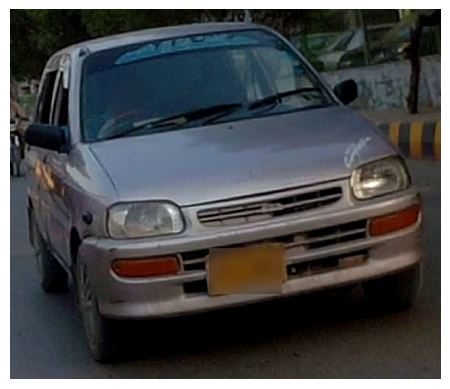

1/1 [==============================] - 0s 24ms/step
Car is Daiatsu_Core


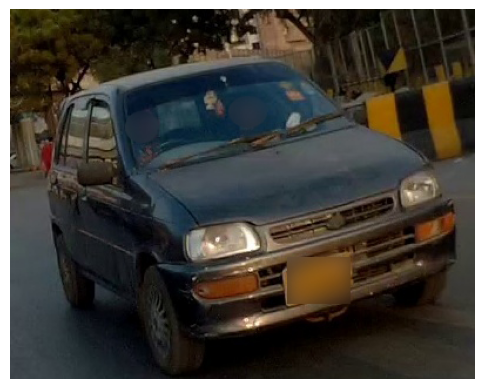

1/1 [==============================] - 0s 25ms/step
Car is Daiatsu_Core


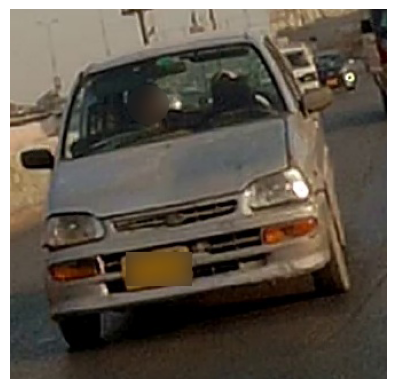

1/1 [==============================] - 0s 23ms/step
Car is Daiatsu_Core


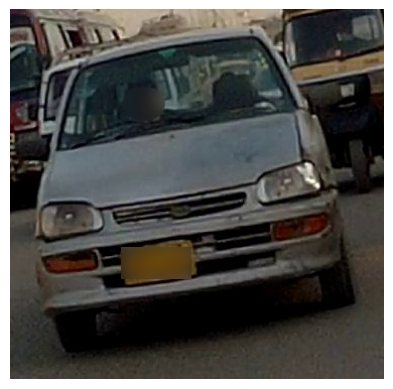

1/1 [==============================] - 0s 23ms/step
Car is Daiatsu_Core


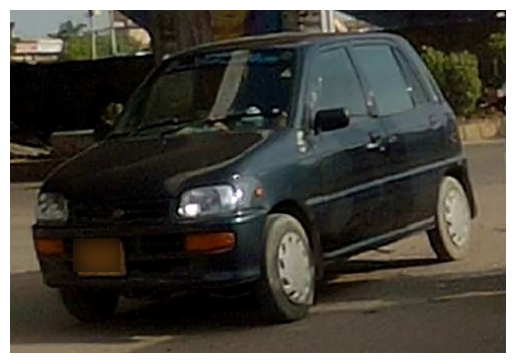

1/1 [==============================] - 0s 24ms/step
Car is Daiatsu_Mira


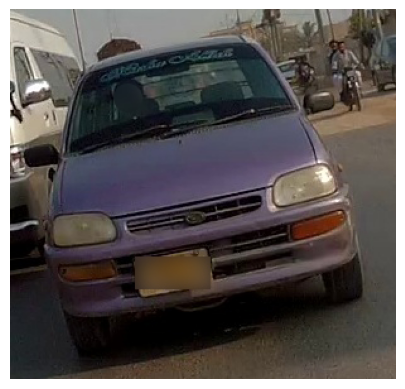

1/1 [==============================] - 0s 23ms/step
Car is Daiatsu_Core


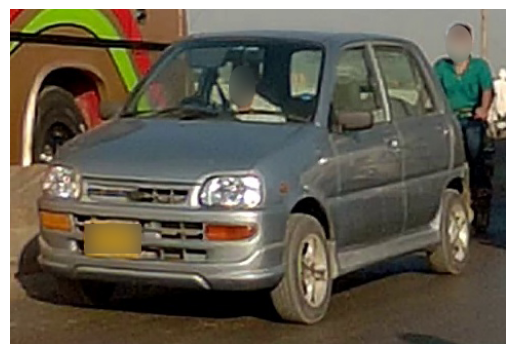

1/1 [==============================] - 0s 23ms/step
Car is Toyota_Aqua


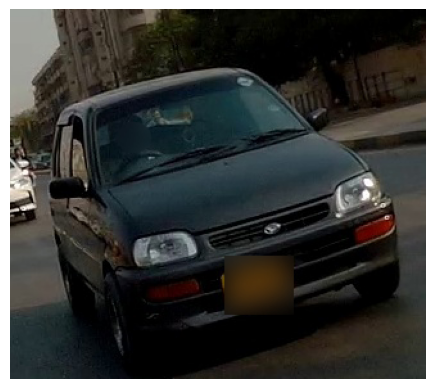

1/1 [==============================] - 0s 22ms/step
Car is Daiatsu_Core


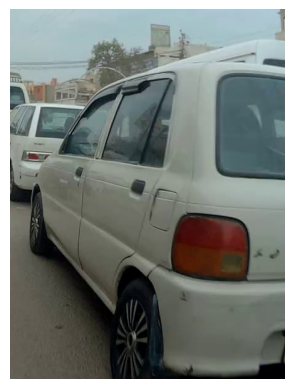

1/1 [==============================] - 0s 20ms/step
Car is Suzuki_cultus_2018


In [10]:
pred_dir = "/kaggle/input/datahack/hj3vvx5946-1/Splited_dataset/test/Daiatsu_Core/"
import random
pred_files = random.sample(os.listdir(pred_dir),10)
for f in pred_files:
    prediction(pred_dir+f)